# Residual Networks

Welcome to the first assignment of this week! You'll be building a very deep convolutional network, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously feasible.

**By the end of this assignment, you'll be able to:**

- Implement the basic building blocks of ResNets in a deep neural network using Keras
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification
- Implement a skip connection in your network

For this assignment, you'll use Keras. 

Before jumping into the problem, run the cell below to load the required packages.

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Content

- [1 - Packages](#1)
- [2 - The Problem of Very Deep Neural Networks](#2)
- [3 - Building a Residual Network](#3)
    - [3.1 - The Identity Block](#3-1)
        - [Exercise 1 - identity_block](#ex-1)
    - [3.2 - The Convolutional Block](#3-2)
        - [Exercise 2 - convolutional_block](#ex-2)
- [4 - Building Your First ResNet Model (50 layers)](#4)
    - [Exercise 3 - ResNet50](#ex-3)
- [5 - Test on Your Own Image (Optional/Ungraded)](#5)
- [6 - Bibliography](#6)

<a name='1'></a>
## 1 - Packages

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator
import public_tests

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

<a name='2'></a>
## 2 - The Problem of Very Deep Neural Networks

Last week, you built your first convolutional neural networks: first manually with numpy, then using Tensorflow and Keras. 

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values). 

* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds, as shown below: 

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Vanishing gradient</b> <br> The speed of learning decreases very rapidly for the shallower layers as the network trains </center></caption>

Not to worry! You are now going to solve this problem by building a Residual Network!

<a name='3'></a>
## 3 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

The lecture mentioned that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

<a name='3-1'></a>
### 3.1 - The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

These are the individual steps:

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

<a name='ex-1'></a>
### Exercise 1 - identity_block

Implement the ResNet identity block. The first component of the main path has been implemented for you already! First, you should read these docs carefully to make sure you understand what's happening. Then, implement the rest. 
- To implement the Conv2D step: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- To implement BatchNorm: [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) `BatchNormalization(axis = 3)(X, training = training)`. If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package [tensorflow.keras.initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) or any other custom initializer. By default it will be set to [random_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomUniform)

Remember that these functions accept a `seed` argument that can be any value you want, but that in this notebook must set to 0 for **grading purposes**.

 Here is where you're actually using the power of the Functional API to create a shortcut path: 

In [2]:
# UNQ_C1
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X) 


    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    ### END CODE HERE

    return X

    ### END CODE HERE

    return X

In [3]:
### you cannot edit this cell

np.random.seed(1)
tf.random.set_seed(2)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
tf.random.set_seed(2)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

public_tests.identity_block_test(identity_block)

With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.6542  192.6542  192.6542   96.8271 ]
  [ 96.8271   96.8271   96.8271   48.91355]]

 [[578.21246 578.21246 578.21246 290.60623]
  [290.60623 290.60623 290.60623 146.80312]]]
96.827095

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.9999  4.9999  4.9999  3.25952]
  [3.25952 3.25952 3.25952 2.40739]]]
All tests passed!


**Expected value**

```
With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.6542  192.6542  192.6542   96.8271 ]
  [ 96.8271   96.8271   96.8271   48.91355]]

 [[578.21246 578.21246 578.21246 290.60623]
  [290.60623 290.60623 290.60623 146.80312]]]
96.827095

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.9999  4.9999  4.9999  3.25952]
  [3.25952 3.25952 3.25952 2.40739]]]
All tests passed!
```

<a name='3-2'></a>
### 3.2 - The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 
* As for the previous exercise, the additional `initializer` argument is required for grading purposes, and it has been set by default to [glorot_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
 
<a name='ex-2'></a>    
### Exercise 2 - convolutional_block
    
Implement the convolutional block. The first component of the main path is already implemented; then it's your turn to implement the rest! As before, always use 0 as the seed for the random initialization, to ensure consistency with the grader.
- [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis)) `BatchNormalization(axis = 3)(X, training = training)`. If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
- For the activation, use:  `Activation('relu')(X)`
- [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)
    
We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package [tensorflow.keras.initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) or any other custom initializer. By default it will be set to [glorot_uniform](https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/keras/initializers/GlorotUniform)

Remember that these functions accept a `seed` argument that can be any value you want, but that in this notebook must set to 0 for **grading purposes**.

In [4]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)

    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
### you cannot edit this cell

public_tests.convolutional_block_test(convolutional_block)

tf.Tensor(
[[[0.         0.         0.6442667  0.         0.13945118 0.78498244]
  [0.01695363 0.         0.7052939  0.         0.27986753 0.67453355]]

 [[0.         0.         0.6702033  0.         0.18277727 0.7506114 ]
  [0.         0.         0.68768525 0.         0.25753927 0.6794529 ]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


**Expected value**

```
tf.Tensor(
[[[0.         0.         0.6442667  0.         0.13945118 0.78498244]
  [0.01695363 0.         0.7052939  0.         0.27986753 0.67453355]]

 [[0.         0.         0.6702033  0.         0.18277727 0.7506114 ]
  [0.         0.         0.68768525 0.         0.25753927 0.6794529 ]]], shape=(2, 2, 6), dtype=float32)
```

<a name='4'></a>  
## 4 - Building Your First ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

    
<a name='ex-3'></a>      
### Exercise 3 - ResNet50 
    
Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2) Make sure you follow the naming convention in the text above. 

You'll need to use this function: 
- Average pooling [see reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)

Here are some other functions we used in the code below:
- Conv2D: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- BatchNorm: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D)
- Max pooling: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
- Fully connected layer: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- Addition: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

In [6]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
  
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2) 
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    
    X = convolutional_block(X, f=3, filters=[256, 256, 1024],s=2) 
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048],s=2) 
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X) 
        
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Run the following code to build the model's graph. If your implementation is incorrect, you'll know it by checking your accuracy when running `model.fit(...)` below.

In [7]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_20 (BatchN  (None, 32, 32, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                

In [8]:
### you cannot edit this cell

from outputs import ResNet50_summary

model = ResNet50(input_shape = (64, 64, 3), classes = 6)

comparator(summary(model), ResNet50_summary)


All tests passed!


As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need now is a dataset!

Let's load your old friend, the SIGNS dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 6</b> </u><font color='purple'>  : <b>SIGNS dataset</b> </center></caption>


In [10]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Run the following cell to train your model on 10 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes. 

In [11]:
model.fit(X_train, Y_train, epochs = 15, batch_size = 32)

Epoch 1/15
34/34 [==============================] - 6s 41ms/step - loss: 1.8323 - accuracy: 0.4731
Epoch 2/15
34/34 [==============================] - 1s 24ms/step - loss: 0.6543 - accuracy: 0.7556
Epoch 3/15
34/34 [==============================] - 1s 24ms/step - loss: 0.5294 - accuracy: 0.8389
Epoch 4/15
34/34 [==============================] - 1s 25ms/step - loss: 0.4418 - accuracy: 0.8574
Epoch 5/15
34/34 [==============================] - 1s 24ms/step - loss: 0.3165 - accuracy: 0.8972
Epoch 6/15
34/34 [==============================] - 1s 24ms/step - loss: 0.1851 - accuracy: 0.9343
Epoch 7/15
34/34 [==============================] - 1s 24ms/step - loss: 0.2016 - accuracy: 0.9389
Epoch 8/15
34/34 [==============================] - 1s 24ms/step - loss: 0.1285 - accuracy: 0.9657
Epoch 9/15
34/34 [==============================] - 1s 24ms/step - loss: 0.0537 - accuracy: 0.9861
Epoch 10/15
34/34 [==============================] - 1s 24ms/step - loss: 0.0880 - accuracy: 0.9741
Epoch 11/

**Expected Output**:

```
Epoch 1/10
34/34 [==============================] - 1s 34ms/step - loss: 1.9241 - accuracy: 0.4620
Epoch 2/10
34/34 [==============================] - 2s 57ms/step - loss: 0.6403 - accuracy: 0.7898
Epoch 3/10
34/34 [==============================] - 1s 24ms/step - loss: 0.3744 - accuracy: 0.8731
Epoch 4/10
34/34 [==============================] - 2s 44ms/step - loss: 0.2220 - accuracy: 0.9231
Epoch 5/10
34/34 [==============================] - 2s 57ms/step - loss: 0.1333 - accuracy: 0.9583
Epoch 6/10
34/34 [==============================] - 2s 52ms/step - loss: 0.2243 - accuracy: 0.9444
Epoch 7/10
34/34 [==============================] - 2s 48ms/step - loss: 0.2913 - accuracy: 0.9102
Epoch 8/10
34/34 [==============================] - 1s 30ms/step - loss: 0.2269 - accuracy: 0.9306
Epoch 9/10
34/34 [==============================] - 2s 46ms/step - loss: 0.1113 - accuracy: 0.9630
Epoch 10/10
34/34 [==============================] - 2s 57ms/step - loss: 0.0709 - accuracy: 0.9778
```

The exact values could not match, but don't worry about that. The important thing that you must see is that the loss value decreases, and the accuracy increases for the firsts 5 epochs.

Let's see how this model (trained on only two epochs) performs on the test set.

In [12]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 10ms/step - loss: 0.3387 - accuracy: 0.9417
Loss = 0.33873048424720764
Test Accuracy = 0.9416666626930237


**Expected Output**:

<table>
    <tr>
        <td>
            <b>Test Accuracy</b>
        </td>
        <td>
           >0.80
        </td>
    </tr>

</table>

For the purposes of this assignment, you've been asked to train the model for ten epochs. You can see that it performs well. The online grader will only run your code for a small number of epochs as well. Please go ahead and submit your assignment. 

After you have finished this official (graded) part of this assignment, you can also optionally train the ResNet for more iterations, if you want. It tends to get much better performance when trained for ~20 epochs, but this does take more than an hour when training on a CPU. 

Using a GPU, this ResNet50 model's weights were trained on the SIGNS dataset. You can load and run the trained model on the test set in the cells below. It may take ≈1min to load the model. Have fun! 

In [14]:
pre_trained_model = tf.keras.models.load_model('resnet50.h5')

In [15]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 8ms/step - loss: 0.1596 - accuracy: 0.9500
Loss = 0.1595880389213562
Test Accuracy = 0.949999988079071


**Congratulations** on finishing this assignment! You've now implemented a state-of-the-art image classification system! Woo hoo! 

ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.

<font color = 'blue'>

**What you should remember**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main types of blocks: The **identity block** and the **convolutional block**. 
- Very deep Residual Networks are built by stacking these blocks together.

## Free Up Resources for Other Learners

If you don't plan on continuing to the next `Optional` section, help us to provide our learners a smooth learning experience, by freeing up the resources used by your assignment by running the cell below so that the other learners can take advantage of those resources just as much as you did. Thank you!

**Note**: 
- Run the cell below when you are done with the assignment and are ready to submit it for grading.
- When you'll run it, a pop up will open, click `Ok`.
- Running the cell will `restart the kernel`.

In [ ]:
# %%javascript
# IPython.notebook.save_checkpoint();
# if (confirm("Clear memory?") == true)
# {
#     IPython.notebook.kernel.restart();
# }

<a name='5'></a>  
## 5 - Test on Your Own Image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 26ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.03917843 0.00125437 0.00150025 0.48205343 0.46265104 0.01336252]]
Class: 3


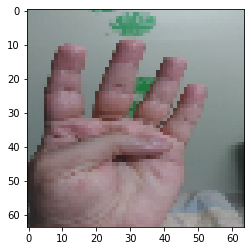

In [24]:
img_path = 'images/three_v6.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))


Even though the model has high accuracy, it might be performing poorly on your own set of images. Notice that, the shape of the pictures, the lighting where the photos were taken, and all of the preprocessing steps can have an impact on the performance of the model. Considering everything you have learned in this specialization so far, what do you think might be the cause here?

*Hint*: It might be related to some distributions. Can you come up with a potential solution ?

You can also print a summary of your model by running the following code.

In [ ]:
pre_trained_model.summary()

## Free Up Resources for Other Learners

In order to provide our learners a smooth learning experience, please free up the resources used by your assignment by running the cell below so that the other learners can take advantage of those resources just as much as you did. Thank you!

**Note**: 
- Run the cell below when you are done with the assignment and are ready to submit it for grading.
- When you'll run it, a pop up will open, click `Ok`.
- Running the cell will `restart the kernel`.

In [ ]:
%%javascript
IPython.notebook.save_checkpoint();
if (confirm("Clear memory?") == true)
{
    IPython.notebook.kernel.restart();
}

<a name='6'></a>  
## 6 - Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
